In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from keras.engine import input_layer
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)


def local_model_generate(model, look_back): #초기 모델 생성
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


def dataset_processing(local_dataset, MinMax_scaler, train, test):
    #local_dataset = local_dataset.astype('float32')

    #for i in range(1,num_locals):
    #    local_dataset = scaler.fit_transform(local_dataset)

    #train_size = int(len(local_dataset)*0.67)
    #test_size = len(local_dataset) - train_size

    #train, test = local_dataset[0:train_size, :], local_dataset[train_size:len(local_dataset),:]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print("train test size: ",len(trainX), len(trainY), len(testX), len(testY))
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX, trainY, testY


    
def model_test(local_model, MinMax_scaler, trainX, testX, trainY, testY):
    trainPredict = local_model.predict(trainX)
    testPredict = local_model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    return math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])), math.sqrt(mean_squared_error(testY[0], testPredict[:,0])) #RMSE



In [3]:
#발전기명, 년월일, 설비용량(MW)	01시	02시	03시	04시	05시	06시	07시	08시	09시	10시	11시	12시	13시	14시	15시	16시	17시	18시	19시	20시	21시	22시	23시	24시

dataset1 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_세종.csv', encoding='cp949')
dataset2 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_안산.csv', encoding='cp949')
dataset3 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_영암.csv', encoding='cp949')


In [4]:
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("Before : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

dataset1, dataset2, dataset3 = dataset1.fillna(0), dataset2.fillna(0), dataset3.fillna(0)
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("After : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

Before :  6 5 1
After :  0 0 0


In [5]:
new_dataset1, new_dataset2, new_dataset3 = [], [], []

for i in range(len(dataset1)):
    new_dataset1.extend(dataset1.iloc[i,3:])

for i in range(len(dataset2)):
    new_dataset2.extend(dataset2.iloc[i,3:])

for i in range(len(dataset3)):
    new_dataset3.extend(dataset3.iloc[i,3:])
    
len(new_dataset1), len(new_dataset2), len(new_dataset3)

(40728, 40728, 40728)

#### 데이터 월단위로 나눔
#### 2017.01.01 ~ 2021.08.31

한달 = 1 global epoch => 12+12+12+12+8 = 56 local epoch


In [6]:
num_locals = 3
ratio_train_test = 1.0

period_1 = [31,28,31,23,31,30,31,31,30,31,30,31]
period_2 = [31,28,31,30,31,30,31,31,30,31,30,31]
period_3 = [31,28,31,30,31,30,31,31,30,31,30,31]
period_4 = [31,29,31,30,31,30,31,31,30,31,30,31]
period_5 = [31,28,31,30,31,30,31,31]

scaler = MinMaxScaler(feature_range=(0,1))

for local in range(1,num_locals+1):
    tmp = 0
    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            for k in range(globals()['period_{}'.format(i)][j]):    
                globals()['dataset{}_{}_{}'.format(local,i,j)] = globals()['new_dataset{}'.format(local)][tmp:tmp+globals()['period_{}'.format(i)][j]]
            #print(i,j,len(globals()['dataset{}_{}_{}'.format(local,i,j)]))
            
    tmp3 = 0
    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            tmp3 = tmp3 + len(globals()['dataset{}_{}_{}'.format(local,i,j)])

    print(tmp3, (np.sum(period_1)+np.sum(period_2)+np.sum(period_3)+np.sum(period_4)+np.sum(period_5)))

    for i in range(1,6):
        for j in range(len(globals()['period_{}'.format(i)])):
            globals()['local{}_{}_{}'.format(local,i,j)] = scaler.fit_transform(np.array(globals()['dataset{}_{}_{}'.format(local,i,j)]).reshape(-1, 1))
            
            local_var = globals()['local{}_{}_{}'.format(local,i,j)]
            globals()['train_size{}_{}_{}'.format(local,i,j)] = int(len(local_var)*ratio_train_test)
            globals()['test_size{}_{}_{}'.format(local,i,j)] = len(local_var) - globals()['train_size{}_{}_{}'.format(local,i,j)]
            train_sz,test_sz = globals()['train_size{}_{}_{}'.format(local,i,j)], globals()['test_size{}_{}_{}'.format(local,i,j)]
            
            globals()['train{}_{}_{}'.format(local,i,j)], globals()['test{}_{}_{}'.format(local,i,j)] = local_var[0:train_sz, :], local_var[test_sz:len(local_var),:]
            

1697 1697
1697 1697
1697 1697


In [8]:
look_back = 1
selected_locals = 3
num_layers_list = [0, 1, 2]
local_epoch, local_batch = 30, 24   #배치사이즈 => 
Loss, Val_Loss = [], []

g = 1

RMSE_total_train_lst, RMSE_total_test_lst = [], []


#맨 처음
loss_tmp, val_loss_tmp = [], []
for local in range(1,num_locals+1):
    globals()['local{}_RMSE_train_lst'.format(local)], globals()['local{}_RMSE_test_lst'.format(local)] = [], []
    
    data_now, train, test = globals()['local{}_1_1'.format(local)], globals()['train{}_1_1'.format(local)], globals()['test{}_1_1'.format(local)]
    trainX, testX, trainY, testY = dataset_processing(data_now, scaler, train, test)
    
    globals()['L_Model{}'.format(local)] = 0
    globals()['L_Model{}'.format(local)] = local_model_generate(globals()['L_Model{}'.format(local)], look_back)
    globals()['history{}'.format(local)] = globals()['L_Model{}'.format(local)].fit(trainX, trainY, 
                                       validation_data=(testX, testY), epochs=local_epoch, batch_size=local_batch, verbose=1)
    
    rmse_train, rmse_test = model_test(globals()['L_Model{}'.format(local)], scaler, trainX, testX, trainY, testY)
    globals()['local{}_RMSE_train_lst'.format(local)].append(rmse_train)
    globals()['local{}_RMSE_test_lst'.format(local)].append(rmse_test)
    
    loss_tmp.append(globals()['history{}'.format(local)].history['loss'])
    val_loss_tmp.append(globals()['history{}'.format(local)].history['val_loss'])

    globals()['G{}_Model_init'.format(g)], globals()['G{}_Model'.format(g)] = Sequential(), 0
    globals()['G{}_Model_init'.format(g)] = local_model_generate(globals()['G{}_Model'.format(g)], look_back)
    
    for layer_index in num_layers_list:
        w=0
        for i in range(selected_locals):            
            w = w + np.array(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) #get_weights = w[0],b[1]로 구성
        w = np.array(w)/(num_locals - 1)
        
        globals()['G{}_Model_init'.format(g)].layers[layer_index].set_weights(w)
        
Loss.append(loss_tmp)
Val_Loss.append(val_loss_tmp)

train test size:  20 20 20 20
Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.1315 - val_loss: 0.1290
Epoch 2/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1290 - val_loss: 0.1266
Epoch 3/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1266 - val_loss: 0.1242
Epoch 4/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1242 - val_loss: 0.1219
Epoch 5/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1219 - val_loss: 0.1196
Epoch 6/30
1/1 [==============================] - 0s 19ms/step - loss: 0.1196 - val_loss: 0.1174
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1174 - val_loss: 0.1152
Epoch 8/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1152 - val_loss: 0.1131
Epoch 9/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1131 - val_loss: 0.1111
Epoch 10/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1111 - val_loss: 0.1091
E

Epoch 22/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1821 - val_loss: 0.1798
Epoch 23/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1798 - val_loss: 0.1776
Epoch 24/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1776 - val_loss: 0.1754
Epoch 25/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1754 - val_loss: 0.1733
Epoch 26/30
1/1 [==============================] - 0s 18ms/step - loss: 0.1733 - val_loss: 0.1712
Epoch 27/30
1/1 [==============================] - 0s 20ms/step - loss: 0.1712 - val_loss: 0.1692
Epoch 28/30
1/1 [==============================] - 0s 20ms/step - loss: 0.1692 - val_loss: 0.1672
Epoch 29/30
1/1 [==============================] - 0s 19ms/step - loss: 0.1672 - val_loss: 0.1653
Epoch 30/30
1/1 [==============================] - 0s 12ms/step


In [9]:
G1_Model = Sequential()
G1_Model = local_model_generate(G1_Model, look_back)
tmp, tmp2 = 0, 0

for i in range(1,5):  #2021년 자료는 test 용
    for j in range(len(globals()['period_{}'.format(i)])):
        loss_tmp = []
        if i == 1 and j == 1:  #아까 맨처음 case
            pass

        else:
            for local in range(1,num_locals+1):
                data_now, train, test = globals()['local{}_{}_{}'.format(local,i,j)], globals()['train{}_{}_{}'.format(local,i,j)], globals()['test{}_{}_{}'.format(local,i,j)]
                trainX, testX, trainY, testY = dataset_processing(data_now, scaler, train, test)

                globals()['L_Model{}'.format(local)] = 0
                globals()['L_Model{}'.format(local)] = local_model_generate(globals()['L_Model{}'.format(local)], look_back)
                globals()['history{}'.format(local)] = globals()['L_Model{}'.format(local)].fit(trainX, trainY, 
                                       validation_data=(testX, testY), epochs=local_epoch, batch_size=local_batch, verbose=2)
                
                #rmse_train, rmse_test = model_test(globals()['L_Model{}'.format(local)], scaler, trainX, testX, trainY, testY)
                #globals()['local{}_RMSE_train_lst'.format(local)].append(rmse_train)
                #globals()['local{}_RMSE_test_lst'.format(local)].append(rmse_test)
                #tmp, tmp2 = tmp + rmse_train, tmp2 + rmse_test
                loss_tmp.append(globals()['history{}'.format(local)].history['loss'])
                val_loss_tmp.append(globals()['history{}'.format(local)].history['val_loss'])
                
            globals()['G{}_Model'.format(g)] = G1_Model_init  #그 전 모델, 어짜피 크기때문에 넣음
            
            for layer_index in num_layers_list:
                w=0
                for i in range(selected_locals):            
                    w = w + np.array(globals()['L_Model{}'.format(local)].layers[layer_index].get_weights()) #get_weights = w[0],b[1]로 구성
                w = np.array(w)/(num_locals - 1)

                globals()['G{}_Model'.format(g)].layers[layer_index].set_weights(w)

            Loss.append(loss_tmp)
            Val_Loss.append(val_loss_tmp)
            g = g + 1
            
            print("Global Epoch : ", g, "\n\n\n")


train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1289 - val_loss: 0.1266 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1266 - val_loss: 0.1244 - 18ms/epoch - 18ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1244 - val_loss: 0.1222 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1222 - val_loss: 0.1201 - 16ms/epoch - 16ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1201 - val_loss: 0.1181 - 17ms/epoch - 17ms/step
Epoch 6/30
1/1 - 0s - loss: 0.1181 - val_loss: 0.1161 - 16ms/epoch - 16ms/step
Epoch 7/30
1/1 - 0s - loss: 0.1161 - val_loss: 0.1141 - 16ms/epoch - 16ms/step
Epoch 8/30
1/1 - 0s - loss: 0.1141 - val_loss: 0.1123 - 18ms/epoch - 18ms/step
Epoch 9/30
1/1 - 0s - loss: 0.1123 - val_loss: 0.1105 - 19ms/epoch - 19ms/step
Epoch 10/30
1/1 - 0s - loss: 0.1104 - val_loss: 0.1087 - 17ms/epoch - 17ms/step
Epoch 11/30
1/1 - 0s - loss: 0.1087 - val_loss: 0.1070 - 24ms/epoch - 24ms/step
Epoch 12/30
1/1 - 0s - loss: 0.1070 - val_loss: 0.1054 - 19ms/epoch - 19ms/step
Epoch 13/30
1/1 - 0s - 

Epoch 13/30
1/1 - 0s - loss: 0.1292 - val_loss: 0.1273 - 16ms/epoch - 16ms/step
Epoch 14/30
1/1 - 0s - loss: 0.1273 - val_loss: 0.1255 - 17ms/epoch - 17ms/step
Epoch 15/30
1/1 - 0s - loss: 0.1255 - val_loss: 0.1237 - 16ms/epoch - 16ms/step
Epoch 16/30
1/1 - 0s - loss: 0.1237 - val_loss: 0.1220 - 16ms/epoch - 16ms/step
Epoch 17/30
1/1 - 0s - loss: 0.1220 - val_loss: 0.1203 - 16ms/epoch - 16ms/step
Epoch 18/30
1/1 - 0s - loss: 0.1203 - val_loss: 0.1187 - 16ms/epoch - 16ms/step
Epoch 19/30
1/1 - 0s - loss: 0.1187 - val_loss: 0.1171 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.1171 - val_loss: 0.1157 - 16ms/epoch - 16ms/step
Epoch 21/30
1/1 - 0s - loss: 0.1157 - val_loss: 0.1142 - 16ms/epoch - 16ms/step
Epoch 22/30
1/1 - 0s - loss: 0.1142 - val_loss: 0.1129 - 15ms/epoch - 15ms/step
Epoch 23/30
1/1 - 0s - loss: 0.1129 - val_loss: 0.1115 - 17ms/epoch - 17ms/step
Epoch 24/30
1/1 - 0s - loss: 0.1115 - val_loss: 0.1103 - 15ms/epoch - 15ms/step
Epoch 25/30
1/1 - 0s - loss: 0.1103 - va

Epoch 25/30
1/1 - 0s - loss: 0.1074 - val_loss: 0.1064 - 16ms/epoch - 16ms/step
Epoch 26/30
1/1 - 0s - loss: 0.1064 - val_loss: 0.1054 - 17ms/epoch - 17ms/step
Epoch 27/30
1/1 - 0s - loss: 0.1054 - val_loss: 0.1045 - 17ms/epoch - 17ms/step
Epoch 28/30
1/1 - 0s - loss: 0.1045 - val_loss: 0.1036 - 17ms/epoch - 17ms/step
Epoch 29/30
1/1 - 0s - loss: 0.1036 - val_loss: 0.1027 - 17ms/epoch - 17ms/step
Epoch 30/30
1/1 - 0s - loss: 0.1027 - val_loss: 0.1019 - 16ms/epoch - 16ms/step
train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1289 - val_loss: 0.1268 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1268 - val_loss: 0.1248 - 18ms/epoch - 18ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1248 - val_loss: 0.1229 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1229 - val_loss: 0.1210 - 16ms/epoch - 16ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1210 - val_loss: 0.1191 - 17ms/epoch - 17ms/step
Epoch 6/30
1/1 - 0s - loss: 0.1191 - val_loss: 0.1173 - 16ms/epoch - 16ms/step
Epoch 7/30
1/1 - 0s 

Epoch 7/30
1/1 - 0s - loss: 0.0979 - val_loss: 0.0959 - 17ms/epoch - 17ms/step
Epoch 8/30
1/1 - 0s - loss: 0.0959 - val_loss: 0.0940 - 17ms/epoch - 17ms/step
Epoch 9/30
1/1 - 0s - loss: 0.0940 - val_loss: 0.0922 - 16ms/epoch - 16ms/step
Epoch 10/30
1/1 - 0s - loss: 0.0922 - val_loss: 0.0905 - 16ms/epoch - 16ms/step
Epoch 11/30
1/1 - 0s - loss: 0.0905 - val_loss: 0.0888 - 16ms/epoch - 16ms/step
Epoch 12/30
1/1 - 0s - loss: 0.0888 - val_loss: 0.0873 - 16ms/epoch - 16ms/step
Epoch 13/30
1/1 - 0s - loss: 0.0873 - val_loss: 0.0858 - 16ms/epoch - 16ms/step
Epoch 14/30
1/1 - 0s - loss: 0.0858 - val_loss: 0.0844 - 17ms/epoch - 17ms/step
Epoch 15/30
1/1 - 0s - loss: 0.0844 - val_loss: 0.0831 - 17ms/epoch - 17ms/step
Epoch 16/30
1/1 - 0s - loss: 0.0831 - val_loss: 0.0819 - 17ms/epoch - 17ms/step
Epoch 17/30
1/1 - 0s - loss: 0.0819 - val_loss: 0.0808 - 17ms/epoch - 17ms/step
Epoch 18/30
1/1 - 0s - loss: 0.0808 - val_loss: 0.0797 - 16ms/epoch - 16ms/step
Epoch 19/30
1/1 - 0s - loss: 0.0797 - val_l

Epoch 19/30
1/1 - 0s - loss: 0.1258 - val_loss: 0.1241 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.1241 - val_loss: 0.1225 - 16ms/epoch - 16ms/step
Epoch 21/30
1/1 - 0s - loss: 0.1225 - val_loss: 0.1210 - 16ms/epoch - 16ms/step
Epoch 22/30
1/1 - 0s - loss: 0.1210 - val_loss: 0.1195 - 16ms/epoch - 16ms/step
Epoch 23/30
1/1 - 0s - loss: 0.1195 - val_loss: 0.1181 - 16ms/epoch - 16ms/step
Epoch 24/30
1/1 - 0s - loss: 0.1181 - val_loss: 0.1168 - 17ms/epoch - 17ms/step
Epoch 25/30
1/1 - 0s - loss: 0.1168 - val_loss: 0.1156 - 16ms/epoch - 16ms/step
Epoch 26/30
1/1 - 0s - loss: 0.1156 - val_loss: 0.1145 - 16ms/epoch - 16ms/step
Epoch 27/30
1/1 - 0s - loss: 0.1145 - val_loss: 0.1134 - 17ms/epoch - 17ms/step
Epoch 28/30
1/1 - 0s - loss: 0.1134 - val_loss: 0.1123 - 16ms/epoch - 16ms/step
Epoch 29/30
1/1 - 0s - loss: 0.1123 - val_loss: 0.1114 - 17ms/epoch - 17ms/step
Epoch 30/30
1/1 - 0s - loss: 0.1114 - val_loss: 0.1105 - 16ms/epoch - 16ms/step
train test size:  22 22 22 22
Epoch 1/30

train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1749 - val_loss: 0.1723 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1723 - val_loss: 0.1699 - 16ms/epoch - 16ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1699 - val_loss: 0.1674 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1674 - val_loss: 0.1651 - 17ms/epoch - 17ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1651 - val_loss: 0.1627 - 17ms/epoch - 17ms/step
Epoch 6/30
1/1 - 0s - loss: 0.1627 - val_loss: 0.1604 - 16ms/epoch - 16ms/step
Epoch 7/30
1/1 - 0s - loss: 0.1604 - val_loss: 0.1582 - 17ms/epoch - 17ms/step
Epoch 8/30
1/1 - 0s - loss: 0.1582 - val_loss: 0.1560 - 16ms/epoch - 16ms/step
Epoch 9/30
1/1 - 0s - loss: 0.1560 - val_loss: 0.1538 - 16ms/epoch - 16ms/step
Epoch 10/30
1/1 - 0s - loss: 0.1538 - val_loss: 0.1517 - 16ms/epoch - 16ms/step
Epoch 11/30
1/1 - 0s - loss: 0.1517 - val_loss: 0.1497 - 16ms/epoch - 16ms/step
Epoch 12/30
1/1 - 0s - loss: 0.1497 - val_loss: 0.1476 - 16ms/epoch - 16ms/step
Epoch 13/30
1/1 - 0s - 

Epoch 13/30
1/1 - 0s - loss: 0.1406 - val_loss: 0.1383 - 16ms/epoch - 16ms/step
Epoch 14/30
1/1 - 0s - loss: 0.1383 - val_loss: 0.1362 - 16ms/epoch - 16ms/step
Epoch 15/30
1/1 - 0s - loss: 0.1362 - val_loss: 0.1341 - 16ms/epoch - 16ms/step
Epoch 16/30
1/1 - 0s - loss: 0.1341 - val_loss: 0.1321 - 16ms/epoch - 16ms/step
Epoch 17/30
1/1 - 0s - loss: 0.1321 - val_loss: 0.1302 - 16ms/epoch - 16ms/step
Epoch 18/30
1/1 - 0s - loss: 0.1302 - val_loss: 0.1283 - 17ms/epoch - 17ms/step
Epoch 19/30
1/1 - 0s - loss: 0.1283 - val_loss: 0.1266 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.1266 - val_loss: 0.1249 - 16ms/epoch - 16ms/step
Epoch 21/30
1/1 - 0s - loss: 0.1249 - val_loss: 0.1233 - 16ms/epoch - 16ms/step
Epoch 22/30
1/1 - 0s - loss: 0.1233 - val_loss: 0.1218 - 17ms/epoch - 17ms/step
Epoch 23/30
1/1 - 0s - loss: 0.1218 - val_loss: 0.1204 - 16ms/epoch - 16ms/step
Epoch 24/30
1/1 - 0s - loss: 0.1204 - val_loss: 0.1190 - 16ms/epoch - 16ms/step
Epoch 25/30
1/1 - 0s - loss: 0.1190 - va

Epoch 25/30
1/1 - 0s - loss: 0.1152 - val_loss: 0.1136 - 17ms/epoch - 17ms/step
Epoch 26/30
1/1 - 0s - loss: 0.1136 - val_loss: 0.1121 - 17ms/epoch - 17ms/step
Epoch 27/30
1/1 - 0s - loss: 0.1121 - val_loss: 0.1107 - 16ms/epoch - 16ms/step
Epoch 28/30
1/1 - 0s - loss: 0.1107 - val_loss: 0.1093 - 16ms/epoch - 16ms/step
Epoch 29/30
1/1 - 0s - loss: 0.1093 - val_loss: 0.1080 - 16ms/epoch - 16ms/step
Epoch 30/30
1/1 - 0s - loss: 0.1080 - val_loss: 0.1067 - 17ms/epoch - 17ms/step
Global Epoch :  9 



train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1448 - val_loss: 0.1419 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1419 - val_loss: 0.1390 - 17ms/epoch - 17ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1390 - val_loss: 0.1362 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1362 - val_loss: 0.1335 - 17ms/epoch - 17ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1335 - val_loss: 0.1309 - 16ms/epoch - 16ms/step
Epoch 6/30
1/1 - 0s - loss: 0.1309 - val_loss: 0.1283 - 17ms/epoch - 17ms/ste

Epoch 6/30
1/1 - 0s - loss: 0.0975 - val_loss: 0.0954 - 17ms/epoch - 17ms/step
Epoch 7/30
1/1 - 0s - loss: 0.0954 - val_loss: 0.0933 - 17ms/epoch - 17ms/step
Epoch 8/30
1/1 - 0s - loss: 0.0933 - val_loss: 0.0913 - 18ms/epoch - 18ms/step
Epoch 9/30
1/1 - 0s - loss: 0.0913 - val_loss: 0.0894 - 17ms/epoch - 17ms/step
Epoch 10/30
1/1 - 0s - loss: 0.0894 - val_loss: 0.0875 - 16ms/epoch - 16ms/step
Epoch 11/30
1/1 - 0s - loss: 0.0875 - val_loss: 0.0857 - 16ms/epoch - 16ms/step
Epoch 12/30
1/1 - 0s - loss: 0.0857 - val_loss: 0.0841 - 16ms/epoch - 16ms/step
Epoch 13/30
1/1 - 0s - loss: 0.0841 - val_loss: 0.0825 - 16ms/epoch - 16ms/step
Epoch 14/30
1/1 - 0s - loss: 0.0825 - val_loss: 0.0809 - 16ms/epoch - 16ms/step
Epoch 15/30
1/1 - 0s - loss: 0.0809 - val_loss: 0.0795 - 16ms/epoch - 16ms/step
Epoch 16/30
1/1 - 0s - loss: 0.0795 - val_loss: 0.0781 - 16ms/epoch - 16ms/step
Epoch 17/30
1/1 - 0s - loss: 0.0781 - val_loss: 0.0768 - 16ms/epoch - 16ms/step
Epoch 18/30
1/1 - 0s - loss: 0.0768 - val_lo

Epoch 18/30
1/1 - 0s - loss: 0.1022 - val_loss: 0.1009 - 16ms/epoch - 16ms/step
Epoch 19/30
1/1 - 0s - loss: 0.1009 - val_loss: 0.0996 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.0996 - val_loss: 0.0985 - 16ms/epoch - 16ms/step
Epoch 21/30
1/1 - 0s - loss: 0.0985 - val_loss: 0.0974 - 16ms/epoch - 16ms/step
Epoch 22/30
1/1 - 0s - loss: 0.0974 - val_loss: 0.0964 - 15ms/epoch - 15ms/step
Epoch 23/30
1/1 - 0s - loss: 0.0964 - val_loss: 0.0955 - 17ms/epoch - 17ms/step
Epoch 24/30
1/1 - 0s - loss: 0.0955 - val_loss: 0.0946 - 15ms/epoch - 15ms/step
Epoch 25/30
1/1 - 0s - loss: 0.0946 - val_loss: 0.0938 - 17ms/epoch - 17ms/step
Epoch 26/30
1/1 - 0s - loss: 0.0938 - val_loss: 0.0931 - 16ms/epoch - 16ms/step
Epoch 27/30
1/1 - 0s - loss: 0.0931 - val_loss: 0.0924 - 17ms/epoch - 17ms/step
Epoch 28/30
1/1 - 0s - loss: 0.0924 - val_loss: 0.0917 - 16ms/epoch - 16ms/step
Epoch 29/30
1/1 - 0s - loss: 0.0917 - val_loss: 0.0911 - 16ms/epoch - 16ms/step
Epoch 30/30
1/1 - 0s - loss: 0.0911 - va

Epoch 30/30
1/1 - 0s - loss: 0.1130 - val_loss: 0.1124 - 16ms/epoch - 16ms/step
train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1119 - val_loss: 0.1093 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1093 - val_loss: 0.1068 - 17ms/epoch - 17ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1068 - val_loss: 0.1044 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1044 - val_loss: 0.1021 - 17ms/epoch - 17ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1021 - val_loss: 0.0999 - 16ms/epoch - 16ms/step
Epoch 6/30
1/1 - 0s - loss: 0.0999 - val_loss: 0.0977 - 17ms/epoch - 17ms/step
Epoch 7/30
1/1 - 0s - loss: 0.0977 - val_loss: 0.0957 - 16ms/epoch - 16ms/step
Epoch 8/30
1/1 - 0s - loss: 0.0957 - val_loss: 0.0937 - 16ms/epoch - 16ms/step
Epoch 9/30
1/1 - 0s - loss: 0.0937 - val_loss: 0.0919 - 16ms/epoch - 16ms/step
Epoch 10/30
1/1 - 0s - loss: 0.0919 - val_loss: 0.0901 - 16ms/epoch - 16ms/step
Epoch 11/30
1/1 - 0s - loss: 0.0901 - val_loss: 0.0884 - 17ms/epoch - 17ms/step
Epoch 12/30
1/1 - 0s - 

Epoch 12/30
1/1 - 0s - loss: 0.1136 - val_loss: 0.1121 - 16ms/epoch - 16ms/step
Epoch 13/30
1/1 - 0s - loss: 0.1121 - val_loss: 0.1107 - 17ms/epoch - 17ms/step
Epoch 14/30
1/1 - 0s - loss: 0.1107 - val_loss: 0.1093 - 17ms/epoch - 17ms/step
Epoch 15/30
1/1 - 0s - loss: 0.1093 - val_loss: 0.1080 - 17ms/epoch - 17ms/step
Epoch 16/30
1/1 - 0s - loss: 0.1080 - val_loss: 0.1067 - 17ms/epoch - 17ms/step
Epoch 17/30
1/1 - 0s - loss: 0.1067 - val_loss: 0.1055 - 16ms/epoch - 16ms/step
Epoch 18/30
1/1 - 0s - loss: 0.1055 - val_loss: 0.1043 - 16ms/epoch - 16ms/step
Epoch 19/30
1/1 - 0s - loss: 0.1043 - val_loss: 0.1032 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.1032 - val_loss: 0.1021 - 17ms/epoch - 17ms/step
Epoch 21/30
1/1 - 0s - loss: 0.1021 - val_loss: 0.1010 - 17ms/epoch - 17ms/step
Epoch 22/30
1/1 - 0s - loss: 0.1010 - val_loss: 0.1000 - 17ms/epoch - 17ms/step
Epoch 23/30
1/1 - 0s - loss: 0.1000 - val_loss: 0.0990 - 16ms/epoch - 16ms/step
Epoch 24/30
1/1 - 0s - loss: 0.0990 - va

Epoch 24/30
1/1 - 0s - loss: 0.1259 - val_loss: 0.1246 - 16ms/epoch - 16ms/step
Epoch 25/30
1/1 - 0s - loss: 0.1246 - val_loss: 0.1232 - 16ms/epoch - 16ms/step
Epoch 26/30
1/1 - 0s - loss: 0.1232 - val_loss: 0.1220 - 17ms/epoch - 17ms/step
Epoch 27/30
1/1 - 0s - loss: 0.1220 - val_loss: 0.1208 - 16ms/epoch - 16ms/step
Epoch 28/30
1/1 - 0s - loss: 0.1208 - val_loss: 0.1196 - 16ms/epoch - 16ms/step
Epoch 29/30
1/1 - 0s - loss: 0.1196 - val_loss: 0.1185 - 16ms/epoch - 16ms/step
Epoch 30/30
1/1 - 0s - loss: 0.1185 - val_loss: 0.1174 - 16ms/epoch - 16ms/step
train test size:  20 20 20 20
Epoch 1/30
1/1 - 2s - loss: 0.1630 - val_loss: 0.1599 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1599 - val_loss: 0.1569 - 17ms/epoch - 17ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1569 - val_loss: 0.1540 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1540 - val_loss: 0.1511 - 16ms/epoch - 16ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1511 - val_loss: 0.1482 - 17ms/epoch - 17ms/step
Epoch 6/30
1/1 - 0s

Epoch 6/30
1/1 - 0s - loss: 0.1227 - val_loss: 0.1205 - 16ms/epoch - 16ms/step
Epoch 7/30
1/1 - 0s - loss: 0.1205 - val_loss: 0.1185 - 16ms/epoch - 16ms/step
Epoch 8/30
1/1 - 0s - loss: 0.1185 - val_loss: 0.1164 - 16ms/epoch - 16ms/step
Epoch 9/30
1/1 - 0s - loss: 0.1164 - val_loss: 0.1144 - 16ms/epoch - 16ms/step
Epoch 10/30
1/1 - 0s - loss: 0.1144 - val_loss: 0.1125 - 15ms/epoch - 15ms/step
Epoch 11/30
1/1 - 0s - loss: 0.1125 - val_loss: 0.1106 - 17ms/epoch - 17ms/step
Epoch 12/30
1/1 - 0s - loss: 0.1106 - val_loss: 0.1087 - 16ms/epoch - 16ms/step
Epoch 13/30
1/1 - 0s - loss: 0.1087 - val_loss: 0.1069 - 16ms/epoch - 16ms/step
Epoch 14/30
1/1 - 0s - loss: 0.1069 - val_loss: 0.1052 - 17ms/epoch - 17ms/step
Epoch 15/30
1/1 - 0s - loss: 0.1052 - val_loss: 0.1035 - 16ms/epoch - 16ms/step
Epoch 16/30
1/1 - 0s - loss: 0.1035 - val_loss: 0.1019 - 17ms/epoch - 17ms/step
Epoch 17/30
1/1 - 0s - loss: 0.1019 - val_loss: 0.1003 - 17ms/epoch - 17ms/step
Epoch 18/30
1/1 - 0s - loss: 0.1003 - val_lo

Epoch 18/30
1/1 - 0s - loss: 0.1809 - val_loss: 0.1785 - 16ms/epoch - 16ms/step
Epoch 19/30
1/1 - 0s - loss: 0.1785 - val_loss: 0.1761 - 16ms/epoch - 16ms/step
Epoch 20/30
1/1 - 0s - loss: 0.1761 - val_loss: 0.1738 - 17ms/epoch - 17ms/step
Epoch 21/30
1/1 - 0s - loss: 0.1738 - val_loss: 0.1715 - 16ms/epoch - 16ms/step
Epoch 22/30
1/1 - 0s - loss: 0.1715 - val_loss: 0.1693 - 16ms/epoch - 16ms/step
Epoch 23/30
1/1 - 0s - loss: 0.1693 - val_loss: 0.1672 - 17ms/epoch - 17ms/step
Epoch 24/30
1/1 - 0s - loss: 0.1672 - val_loss: 0.1652 - 16ms/epoch - 16ms/step
Epoch 25/30
1/1 - 0s - loss: 0.1652 - val_loss: 0.1632 - 17ms/epoch - 17ms/step
Epoch 26/30
1/1 - 0s - loss: 0.1632 - val_loss: 0.1613 - 16ms/epoch - 16ms/step
Epoch 27/30
1/1 - 0s - loss: 0.1613 - val_loss: 0.1594 - 16ms/epoch - 16ms/step
Epoch 28/30
1/1 - 0s - loss: 0.1594 - val_loss: 0.1576 - 16ms/epoch - 16ms/step
Epoch 29/30
1/1 - 0s - loss: 0.1576 - val_loss: 0.1559 - 16ms/epoch - 16ms/step
Epoch 30/30
1/1 - 0s - loss: 0.1559 - va

Epoch 30/30
1/1 - 0s - loss: 0.1417 - val_loss: 0.1399 - 16ms/epoch - 16ms/step
Global Epoch :  18 



train test size:  22 22 22 22
Epoch 1/30
1/1 - 2s - loss: 0.1587 - val_loss: 0.1561 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.1561 - val_loss: 0.1536 - 18ms/epoch - 18ms/step
Epoch 3/30
1/1 - 0s - loss: 0.1536 - val_loss: 0.1512 - 17ms/epoch - 17ms/step
Epoch 4/30
1/1 - 0s - loss: 0.1512 - val_loss: 0.1489 - 17ms/epoch - 17ms/step
Epoch 5/30
1/1 - 0s - loss: 0.1489 - val_loss: 0.1466 - 17ms/epoch - 17ms/step
Epoch 6/30
1/1 - 0s - loss: 0.1466 - val_loss: 0.1444 - 17ms/epoch - 17ms/step
Epoch 7/30
1/1 - 0s - loss: 0.1444 - val_loss: 0.1423 - 17ms/epoch - 17ms/step
Epoch 8/30
1/1 - 0s - loss: 0.1423 - val_loss: 0.1402 - 17ms/epoch - 17ms/step
Epoch 9/30
1/1 - 0s - loss: 0.1402 - val_loss: 0.1382 - 17ms/epoch - 17ms/step
Epoch 10/30
1/1 - 0s - loss: 0.1382 - val_loss: 0.1363 - 17ms/epoch - 17ms/step
Epoch 11/30
1/1 - 0s - loss: 0.1363 - val_loss: 0.1344 - 16ms/epoch - 16ms/step


KeyboardInterrupt: 

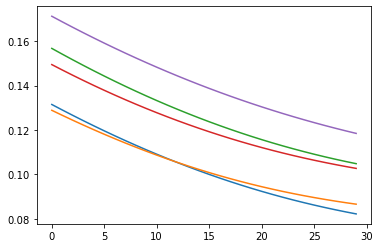

In [27]:
plt.plot(Loss[0][0])
plt.plot(Loss[1][0])
plt.plot(Loss[2][0])
plt.plot(Loss[3][0])
plt.plot(Loss[4][0])

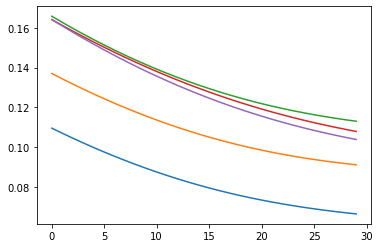

In [28]:
plt.plot(Loss[10][0])
plt.plot(Loss[11][0])
plt.plot(Loss[12][0])
plt.plot(Loss[13][0])
plt.plot(Loss[14][0])

In [18]:
for i in range(len(Loss)):
    print(Loss[i][0][-1])
    
    #, Loss[1][0][-1]

0.08223073184490204
0.08661206066608429
0.10483604669570923
0.10271359235048294
0.11846137046813965
0.09501998871564865
0.10554351657629013
0.0960189625620842
0.08641909807920456
0.09246759116649628
0.06645416468381882
0.09113896638154984
0.11303538829088211
0.10790465027093887
0.10387376695871353
0.10683174431324005
0.09449689835309982
0.06976281851530075


In [14]:
len(Loss[0][0])

30

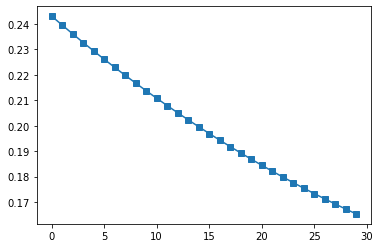

In [20]:
plt.plot(Loss[:][0][-1], marker='s')

In [ ]:
Loss

In [ ]:
len(RMSE_total_train_lst), len(RMSE_total_test_lst)

In [ ]:
plt.plot(RMSE_total_train_lst)

In [ ]:
plt.plot(RMSE_total_test_lst)

In [ ]:
plt.plot(RMSE_total_train_lst)
plt.plot(RMSE_total_test_lst)
plt.show()